<a href="https://colab.research.google.com/github/Baisalis/DS-Unit-2-Linear-Models/blob/master/assignment_regression_classification_4_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

Logistic Regression
Assignment 🌯
You'll use a dataset of 400+ burrito reviews. How accurately can you predict whether a burrito is rated 'Great'?

We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

[ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
[ ] Begin with baselines for classification.
[ ] Use scikit-learn for logistic regression.
[ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
[ ] Get your model's test accuracy. (One time, at the end.)
[ ] Commit your notebook to your fork of the GitHub repo.

In [0]:
Stretch Goals
[ ] Add your own stretch goal(s) !
[ ] Make exploratory visualizations.
[ ] Do one-hot encoding.
[ ] Do feature scaling.
[ ] Get and plot your coefficients.
[ ] Try scikit-learn pipelines.

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [12]:
print(df.shape)
df.head()

(421, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [8]:
df['Date'].describe()

count           421
unique          169
top       8/30/2016
freq             29
Name: Date, dtype: object

In [0]:
# Convert 'Date' to date/time type
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

# Split dataset for model creation
train = df[df['Date'].dt.year < 2017]
val = df[df['Date'].dt.year == 2017]
test = df[(df['Date'].dt.year > 2017) & (df['Date'].dt.year < 2020)]

In [10]:
train.shape, val.shape, test.shape

((298, 59), (85, 59), (37, 59))

In [16]:
#  baselines for classification
target ='Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [19]:
# look at categorical features
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Yelp,71.0,3.897183,0.478680,2.50,3.5000,4.00,4.00,4.50
Google,71.0,4.142254,0.371738,2.90,4.0000,4.20,4.40,4.90
Cost,292.0,6.896781,1.211412,2.99,6.2500,6.85,7.50,11.95
Hunger,297.0,3.445286,0.852150,0.50,3.0000,3.50,4.00,5.00
Mass (g),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Density (g/mL),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length,175.0,19.829886,2.081275,15.00,18.5000,19.50,21.00,26.00
Circum,174.0,22.042241,1.685043,17.00,21.0000,22.00,23.00,27.00
Volume,174.0,0.770920,0.137833,0.40,0.6625,0.75,0.87,1.24
Tortilla,298.0,3.472315,0.797606,1.40,3.0000,3.50,4.00,5.00


In [20]:
# look at numerical features
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Yelp,3.0,3.833333,0.577350,3.50,3.50,3.50,4.00,4.50
Google,3.0,3.966667,0.288675,3.80,3.80,3.80,4.05,4.30
Cost,37.0,7.219730,1.375604,4.19,5.99,7.25,8.00,9.99
Hunger,37.0,3.470270,0.856305,1.00,3.00,3.50,4.00,5.00
Mass (g),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Density (g/mL),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length,33.0,19.848485,2.286116,17.00,18.00,19.50,21.00,25.00
Circum,33.0,22.378788,1.644072,19.00,21.50,22.00,23.50,26.00
Volume,33.0,0.794242,0.144850,0.52,0.68,0.77,0.91,1.07
Tortilla,37.0,3.859459,0.795983,2.00,3.50,4.00,4.50,5.00


In [22]:
train.isnull().sum()

Burrito             0
Date                0
Yelp              227
Google            227
Chips             276
Cost                6
Hunger              1
Mass (g)          298
Density (g/mL)    298
Length            123
Circum            124
Volume            124
Tortilla            0
Temp               15
Meat               10
Fillings            1
Meat:filling        6
Uniformity          2
Salsa              20
Synergy             2
Wrap                2
Unreliable        271
NonSD             293
Beef              130
Pico              155
Guac              159
Cheese            149
Fries             179
Sour cream        213
Pork              255
Chicken           278
Shrimp            278
Fish              293
Rice              265
Beans             266
Lettuce           287
Tomato            291
Bell peper        291
Carrots           297
Cabbage           291
Sauce             261
Salsa.1           292
Cilantro          283
Onion             281
Taquito           294
Pineapple 

In [26]:
import numpy as np

# Convert 'Guac' to numeric to prepare for model
train['Guac'] = train['Guac'].replace({'X':1, 'x':1, np.NaN:0})
val['Guac'] = val['Guac'].replace({'X':1, 'x':1, np.NaN:0})
test['Guac'] = test['Guac'].replace({'X':1, 'x':1, np.NaN:0})

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [27]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

features = ['Burrito', 'Cost', 'Hunger', 'Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Guac']
target = 'Great'
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

# One Hot Encode Burrito Category
encoder = ce.OneHotEncoder(use_cat_names=True, cols='Burrito')
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# Impute NaN values
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

# Scale values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

# Fit the model
model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=16)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.8588235294117647


In [28]:
# Look at coefficients
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values()

Burrito_Surf & Turf   -0.108679
Burrito_Other         -0.078191
Burrito_Asada         -0.015286
Circum                 0.000595
Volume                 0.006054
Burrito_Carnitas       0.018013
Length                 0.047222
Guac                   0.063145
Wrap                   0.070533
Hunger                 0.110365
Burrito_California     0.136297
Uniformity             0.185705
Cost                   0.219594
Salsa                  0.249185
Temp                   0.278074
Tortilla               0.322519
Meat:filling           0.505558
Fillings               0.565861
Meat                   0.584767
Synergy                0.668670
dtype: float64

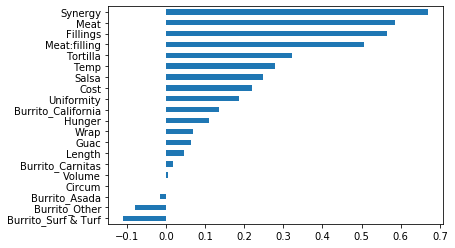

In [29]:
# Plot coefficients 
% matplotlib inline
coefficients.sort_values().plot.barh();

In [30]:
# Look at test accuracy

# Prepare X features and y target
features = ['Burrito', 'Cost', 'Hunger', 'Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Guac']
target = 'Great'
X_test = test[features]
y_test = test[target]

# One Hot Encode Burrito Category
X_test_encoded = encoder.transform(X_test)

# Impute NaN values
X_test_imputed = imputer.transform(X_test_encoded)

# Scale values
X_test_scaled = scaler.transform(X_test_imputed)

# Fit the model
print('Validation Accuracy', model.score(X_test_scaled, y_test))

Validation Accuracy 0.7567567567567568
